In [1]:
%matplotlib inline

# Preprocessing and Spike Sorting Tutorial

# Chapter 1: Importing Recording Data and Metadata

In [2]:
import os
import warnings
import glob
import pickle
import _pickle as cPickle
import imp

/nancy/user/riwata/projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  


In [3]:
from collections import defaultdict
import time
import json

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import scipy.signal

In [5]:
# Changing the figure size
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

The spikeinterface module by itself import only the spikeinterface.core submodule
which is not useful for end user



In [6]:
import spikeinterface

We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [7]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

In [8]:
import spikeinterface.core

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [9]:
import spikeinterface.full as si

In [10]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

# Part 1: Importing Data

## Loading in the Electrophysiology Recording

- Please look at this website to see which importing method matches your data format. https://spikeinterface.readthedocs.io/en/latest/modules/extractors/plot_1_read_various_formats.html#sphx-glr-modules-extractors-plot-1-read-various-formats-py
- You can also try tab completing `se.read_` and see what other electrophysiology data formats are accepted
    - All the different options for importing electrophysiology data:

In [20]:
for method in dir(se):
    if method.startswith("read"):
        print(method)

read_alf_sorting
read_bids_folder
read_blackrock
read_ced
read_combinato
read_hdsort
read_herdingspikes
read_intan
read_kilosort
read_klusta
read_maxwell
read_maxwell_event
read_mcsraw
read_mda_recording
read_mda_sorting
read_mearec
read_neuralynx
read_neuroscope
read_nix
read_nwb
read_nwb_recording
read_nwb_sorting
read_openephys
read_phy
read_plexon
read_shybrid_recording
read_shybrid_sorting
read_spike2
read_spikegadgets
read_spikeglx
read_spykingcircus
read_tridesclous
read_waveclust
read_yass


- Getting a list of all the electrophysiological recording files
    - **NOTE**: If your recording file does not end with `.rec` or is in a different directory than `./data` then you must change `glob.glob({./path/to/recording_file.rec})` below. Where you replace `{./path/to/recording_file.rec}` with the path to your recording file without the brackets.

In [21]:
# Getting all the file paths of the recording files(that happen to all end in `.txt`)
all_recording_files = glob.glob("./data/*.rec")

In [22]:
all_recording_files

['./data/20220907_140232test.rec']

- If you have more than one metadata file, then you must either:
    - A. Put the index of the file in `all_meta_data_files[0]` below. You would replace the `0` with the correct index. (Remember, Python is zero indexed so the first file in the list is 0. Second is 1, and so forth.
    - B. Add a absolute or relative path to `open({./path/to/recording_file.rec})` below. You would replace `{./path/to/recording_file.rec}` with the path of the file for the metadata.

- Reading in the data into Spikeinterface
    - **NOTE**: If you are not using Spikegadgets to record your electrophysiological data, then you must change the `read_spikegadgets` below to the format/device that you are using. Look at list above to see which one matches yours.  

In [24]:
recording = se.read_spikegadgets(all_recording_files[0], stream_id='trodes')

This extractor based on  neo.SpikeGadgetsRawIO have strange units not in (V, mV, uV) ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '']


In [25]:
type(recording)

spikeinterface.extractors.neoextractors.spikegadgets.SpikeGadgetsRecordingExtractor

## Plotting the electrophysiology activity

:code:`recording` is a :code:`RecordingExtractor` object, which extracts information about channel ids, channel locations
(if present), the sampling frequency of the recording, and the extracellular  traces. :code:`sorting_true` is a
:code:`SortingExtractor` object, which contains information about spike-sorting related information,  including unit ids,
spike trains, etc.
Let's use the :code:`widgets` module to visualize the traces and the raster plots.



- Plotting the activity for all channels for the first 5 seconds
    - Check to see if there's any activity.
    - You can adjust the time by changing `time_range=(0, 5)`. The first number is when the plotting starts in seconds, and the second number is the when the plotting ends.

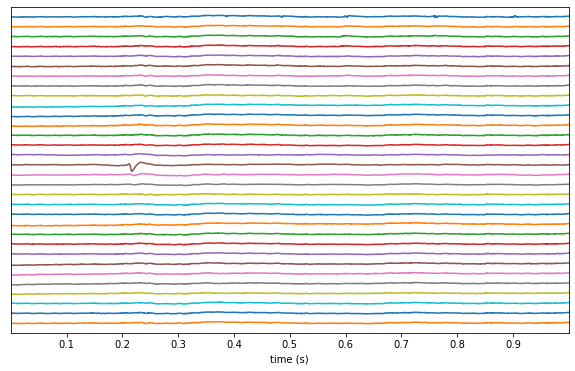

In [26]:
w_ts = sw.plot_timeseries(recording, time_range=(0, 1))


## Metadata from the recording file

This is how you retrieve info from a :code:`RecordingExtractor`...



In [27]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_seg = recording.get_num_segments()
duration = recording.get_num_frames()

print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print('Duration:', duration)
print('Number of hours:', duration/fs/3600)

Channel ids: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31']
Sampling frequency: 20000.0
Number of channels: 32
Number of segments: 1
Duration: 6768567
Number of hours: 0.094007875


:code:`spikeinterface` internally uses the :code:`probeinterface`
to handle Probe and ProbeGroup.
 So any probe in the probeinterface collections can be download
and set to a Recording object.
In this case, the MEArec dataset already handles a Probe and we don't need to set it.



...and a :code:`SortingExtractor`



Using the :code:`toolkit`, you can perform preprocessing on the recordings.
Each pre-processing function also returns a :code:`RecordingExtractor`,
which makes it easy to build pipelines. Here, we filter the recording and
apply common median reference (CMR).
All theses preprocessing steps are "lazy". The computation is done on demand when we call
`recording.get_traces(...)` or when we save the object to disk.



# Part 2: Setting Probes

In [28]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

- Adding the information about the probes used to record the electrophysiology data.
- If you are using different probes, take a look at:
    - https://probeinterface.readthedocs.io/_/downloads/en/latest/pdf/
    - https://spikeinterface.readthedocs.io/en/latest/modules/core/plot_3_handle_probe_info.html#sphx-glr-modules-core-plot-3-handle-probe-info-py

## Reading in a Probe file

In [29]:
# Getting all the file paths of the recording parameter files(that happen to all end in `.prm`)
all_probe_files = glob.glob("./data/*.prb")

In [30]:
all_probe_files

['./data/nancyprobe_linearprobelargespace.prb']

- If you have more than one metadata file, then you must either:
    - A. Put the index of the file in `all_parameter_files[0]` below. You would replace the `0` with the correct index. (Remember, Python is zero indexed so the first file in the list is 0. Second is 1, and so forth.
    - B. Add a absolute or relative path to `open({./path/to/recording_file.rec})` below. You would replace `{./path/to/recording_file.rec}` with the path of the file for the metadata.

In [31]:
if len(all_probe_files) < 1:
    warnings.warn("There are no parameter files in the directory that you specified. Please add a file, or correct the directory path")
else:
    probe_parameters = imp.load_source("probe_parameters", all_probe_files[0])
    with open(all_probe_files[0]) as info_file:
        lines = info_file.readlines()
        for line in lines:
            print(line)

channel_groups = {0: {'channels': [0,

                  1,

                  2,

                  3,

                  4,

                  5,

                  6,

                  7,

                  8,

                  9,

                  10,

                  11,

                  12,

                  13,

                  14,

                  15,

                  16,

                  17,

                  18,

                  19,

                  20,

                  21,

                  22,

                  23,

                  24,

                  25,

                  26,

                  27,

                  28,

                  29,

                  30,

                  31],

     'geometry':{

    0: (0, 0),

    1: (5, 20),

    2: (-7, 40),

    3: (9, 60),

    4: (-11, 80),

    5: (13, 100),

    6: (-15, 120),

    7: (17, 140),

    8: (-19, 160),

    9: (21, 180),

    10: (-23, 200),

    11: (25, 220),

    12: (-27

- Reading in the probe information into Spike interface and plotting the probe

This extractor based on  neo.SpikeGadgetsRawIO have strange units not in (V, mV, uV) ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '']


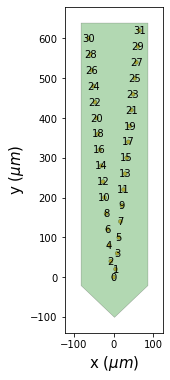

In [32]:
if len(all_probe_files) < 1:
    warnings.warn("There are no parameter files in the directory that you specified. Please add a file, or correct the directory path")
else:
    # Reading in the probe data
    probe_object = read_prb(all_probe_files[0])
    # Setting the probe to the recording object
    recording = recording.set_probes(probe_object)
    # Plotting the probe configuration
    plot_probe_group(probe_object, same_axes=False, with_channel_index=True)
    plt.show()

- Creating a dictionary of all the variables in the probe file

In [33]:
if 'probe_parameters' in locals():
    probe_dict = defaultdict(dict)
    for attribute in dir(probe_parameters):
        # Removing built in attributes
        if not attribute.startswith("__"): 
            probe_dict[attribute] = getattr(probe_parameters, attribute)

In [34]:
if "probe_dict" in locals():
    for key, value in probe_dict.items():
        print("{}: {}".format(key, value))

channel_groups: {0: {'channels': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], 'geometry': {0: (0, 0), 1: (5, 20), 2: (-7, 40), 3: (9, 60), 4: (-11, 80), 5: (13, 100), 6: (-15, 120), 7: (17, 140), 8: (-19, 160), 9: (21, 180), 10: (-23, 200), 11: (25, 220), 12: (-27, 240), 13: (29, 260), 14: (-31, 280), 15: (33, 300), 16: (-35, 320), 17: (37, 340), 18: (-39, 360), 19: (41, 380), 20: (-43, 400), 21: (45, 420), 22: (-47, 440), 23: (49, 460), 24: (-51, 480), 25: (53, 500), 26: (-55, 520), 27: (57, 540), 28: (-59, 560), 29: (61, 580), 30: (-63, 600), 31: (65, 620)}, 'graph': [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31)]}}


# Part 2.1 Making a probe from scratch

## NOTE: If you do not have a probe file, you must make a probe from scratch

In [35]:
import itertools

In [36]:
from probeinterface import Probe, ProbeGroup
from probeinterface import Probe
from probeinterface.plotting import plot_probe_group
from probeinterface.plotting import plot_probe

In [37]:
from probeinterface import generate_linear_probe, generate_multi_shank
from probeinterface.generator import generate_tetrode
from probeinterface.generator import generate_linear_probe
from probeinterface.generator import generate_multi_columns_probe

- Making 8 tetrodes for 32 channels

In [38]:
probegroup = ProbeGroup()
# The difference in position for the X and Y axis of all the tetrodes
x_difference = [0, 40, 80, 120]
y_difference = [0, 40]
# Getting a combination of all the X and Y differences
difference_combinations = list(itertools.product(x_difference, y_difference))

for num in range(8):   
    # Creating a new tetrode
    current_tetrode = generate_tetrode()
    # Moving the tetrode
    current_tetrode.move([difference_combinations[num][0], difference_combinations[num][1]])
    # Adding the tetrode to the group
    probegroup.add_probe(current_tetrode)

# Setting the indices of the channels
probegroup.set_global_device_channel_indices(np.arange(32))

In [39]:
# Number of channels
probegroup.get_channel_count()

32

In [40]:
# The IDs of the probes
probegroup.get_global_device_channel_indices()

array([(0,  0), (0,  1), (0,  2), (0,  3), (1,  4), (1,  5), (1,  6),
       (1,  7), (2,  8), (2,  9), (2, 10), (2, 11), (3, 12), (3, 13),
       (3, 14), (3, 15), (4, 16), (4, 17), (4, 18), (4, 19), (5, 20),
       (5, 21), (5, 22), (5, 23), (6, 24), (6, 25), (6, 26), (6, 27),
       (7, 28), (7, 29), (7, 30), (7, 31)],
      dtype=[('probe_index', '<i8'), ('device_channel_indices', '<i8')])

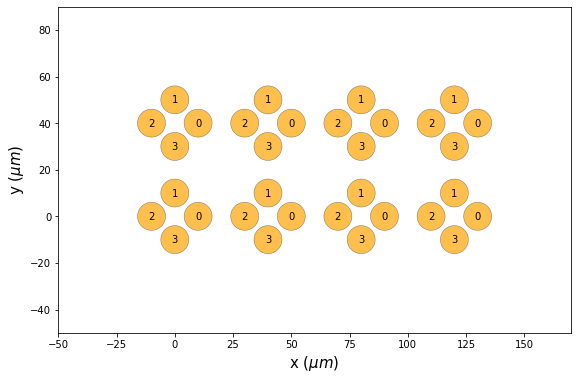

In [41]:
# What all the probes look like
plot_probe_group(probegroup, same_axes=True, with_channel_index=True)

In [42]:
# The X and Y position of the probes
probegroup.to_dataframe().head(n=12)

,probe_index,x,y,contact_shapes,radius,shank_ids,contact_ids
0,0,1.000000e+01,0.000000e+00,circle,6.0,,
1,0,6.123234e-16,1.000000e+01,circle,6.0,,
2,0,-1.000000e+01,1.224647e-15,circle,6.0,,
3,0,-1.836970e-15,-1.000000e+01,circle,6.0,,
4,1,1.000000e+01,4.000000e+01,circle,6.0,,
5,1,6.123234e-16,5.000000e+01,circle,6.0,,
6,1,-1.000000e+01,4.000000e+01,circle,6.0,,
7,1,-1.836970e-15,3.000000e+01,circle,6.0,,
8,2,5.000000e+01,0.000000e+00,circle,6.0,,
9,2,4.000000e+01,1.000000e+01,circle,6.0,,


- Uncomment this if you want to use the tetrodes as the probes instead

### Multishank Probe

In [43]:
multi_shank = generate_multi_shank(num_shank=32, num_columns=1, num_contact_per_column=1)

(<matplotlib.collections.PolyCollection at 0x7ff6b3009090>,
 <matplotlib.collections.PolyCollection at 0x7ff6b307cdd0>)

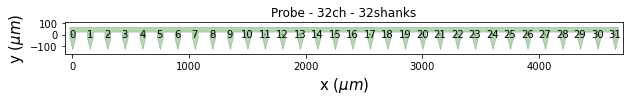

In [44]:
plot_probe(multi_shank, with_channel_index=True)

In [45]:
multi_shank.set_device_channel_indices(np.arange(num_chan))

- Turn the cell below into a code block if you want to use the multishank probes as the probes instead

In [46]:
recording = recording.set_probes(multi_shank)

This extractor based on  neo.SpikeGadgetsRawIO have strange units not in (V, mV, uV) ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '']


# Saving the Recording Files for the Next Notebook

- Creating an output folder based on the recording file name

In [47]:
recording_file_name = os.path.basename(all_recording_files[0])
recording_file_root = os.path.splitext(recording_file_name)[0]

In [48]:
recording_file_root

'20220907_140232test'

- Alternatively, you can use the file name provided by the metadata file or the experiment name in the parameter file
    - If you want to use either of these, you must make the boxes below into a code block

In [49]:
parent_output_directory = "./proc/{}".format(recording_file_root)

In [50]:
parent_output_directory

'./proc/20220907_140232test'

In [51]:
os.makedirs(parent_output_directory, exist_ok=True)

In [52]:
recording_output_directory = os.path.join(parent_output_directory, "recording_raw")


In [53]:
recording_output_directory

'./proc/20220907_140232test/recording_raw'

In [54]:
if not os.path.exists(recording_output_directory):
    recording.save_to_folder(name="recording_raw", folder=recording_output_directory)
else:
    warnings.warn("""Directory already exists for: {}. 
    Either continue on if you are satisfied with the previous run 
    or delete the directory and run this cell again""".format(recording_output_directory))

write_binary_recording with n_jobs 1  chunk_size None
This extractor based on  neo.SpikeGadgetsRawIO have strange units not in (V, mV, uV) ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '']


## 